In [1]:
import torch
import numpy as np
from torch import nn
from skimage.io import imshow
import matplotlib.pyplot as plt
from skimage.io import imshow
import matplotlib

from interpolation import two_point_interpolation, analogies,gaussian_interpolation,\
    n_point_interpolation,vicinity_sampling
%matplotlib inline

In [2]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
)

In [3]:
def plot_torch_picture(tensor, ax=None):
    tensor_to_print = (tensor + 1) / 2
    tensor_to_print = (tensor_to_print * 255).int()
    if ax is None:
        plt.imshow(tensor_to_print.squeeze(0).detach().permute(1,2,0).data.numpy())
        plt.axis('off')
        plt.show()
    else:
        ax.axis('off')
        ax.imshow(tensor_to_print.squeeze(0).detach().permute(1,2,0).data.numpy())

In [4]:
ngpu = 1
nz = 100
ngf = 64
ndf = 64
nc = 3

In [5]:
netG = Generator(ngpu=ngpu).to('cpu')

In [6]:
netG.load_state_dict(torch.load('CelebA/netG_epoch_24.pth', map_location='cpu'))

In [7]:
netG.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

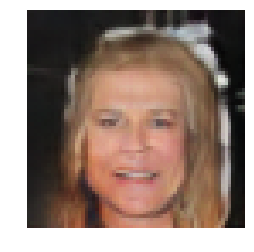

In [9]:
rand = torch.randn(1, 100, 1, 1, device='cpu')
plot_torch_picture(netG.main(rand))

### 2 point Interpolation

In [10]:
def interpolation_sequence_generation(list_t):
    rand1 = torch.randn(1, 100, 1, 1, device='cpu')
    rand2 = torch.randn(1, 100, 1, 1, device='cpu')
    interpolation_ot =[]
    interpolation_no_scale = []
    for t in reversed(list_t):
        interpolation_ot.append(two_point_interpolation(rand1, rand2, t=t, do_scale=True))
        interpolation_no_scale.append(two_point_interpolation(rand1, rand2,t = t, do_scale=False))
    
    output1 = netG.main(rand1)
    output2 = netG.main(rand2)

    fig, axs = plt.subplots(nrows=2, ncols=len(list_t)+2, sharex=True,figsize = (20,5))

    plot_torch_picture(output1, ax = axs[0,0])
    plot_torch_picture(output2, ax = axs[0,len(list_t)+1])
    plot_torch_picture(output1, ax = axs[1,0])
    plot_torch_picture(output2, ax = axs[1,len(list_t)+1])
    for i in range(len(list_t)):
        plot_torch_picture(netG.main(interpolation_ot[i]), ax = axs[0,i+1])
        plot_torch_picture(netG.main(interpolation_no_scale[i]), ax = axs[1,i+1])
    pass

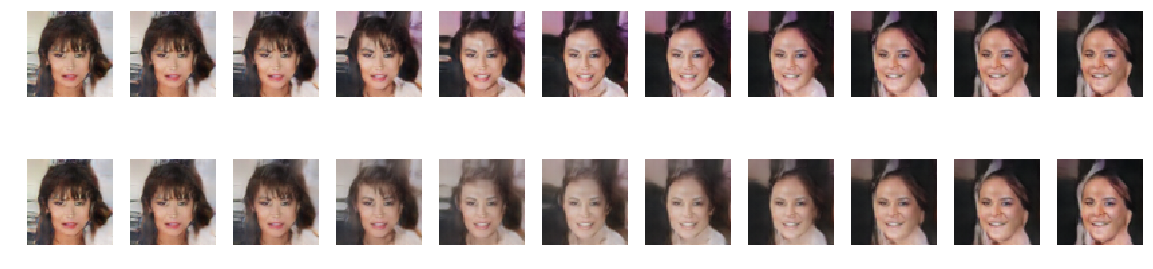

In [18]:
list_t = np.linspace(0.1, 0.9, 9)

interpolation_sequence_generation(list_t)

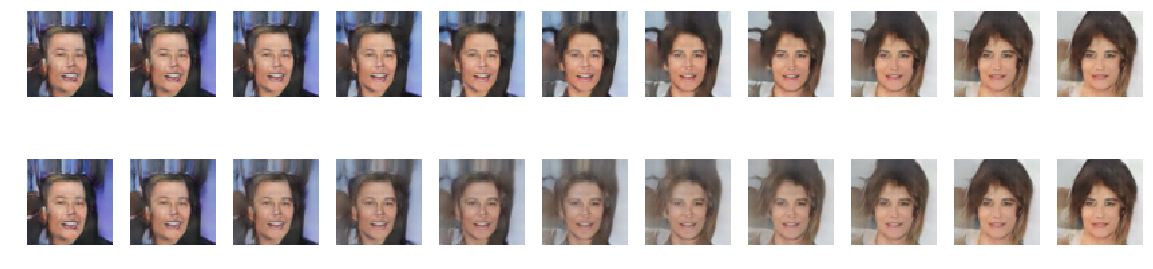

In [76]:
interpolation_sequence_generation(list_t)

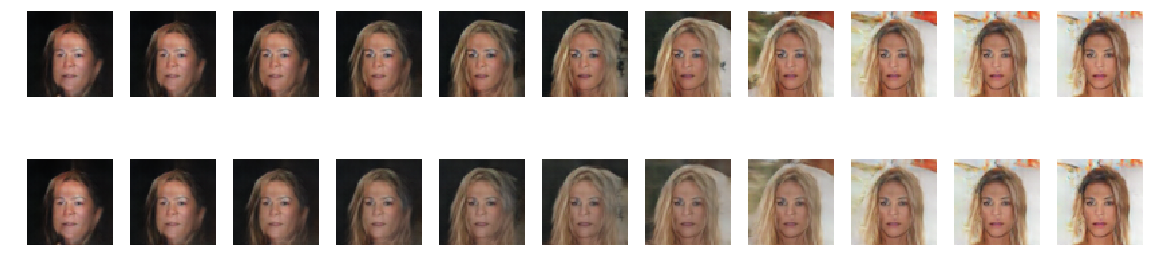

In [23]:
interpolation_sequence_generation(list_t)

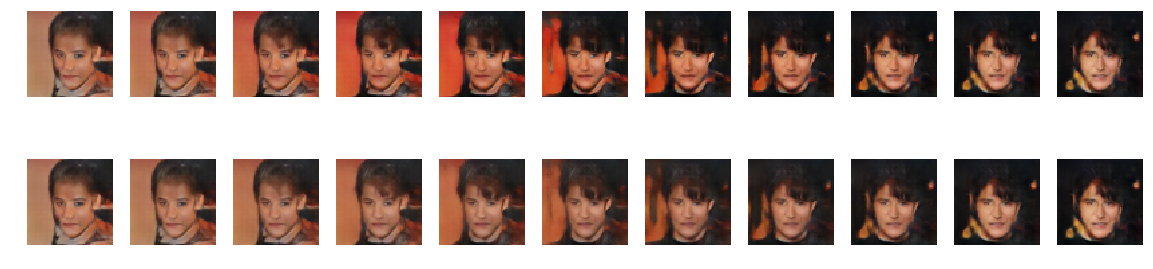

In [24]:
interpolation_sequence_generation(list_t)

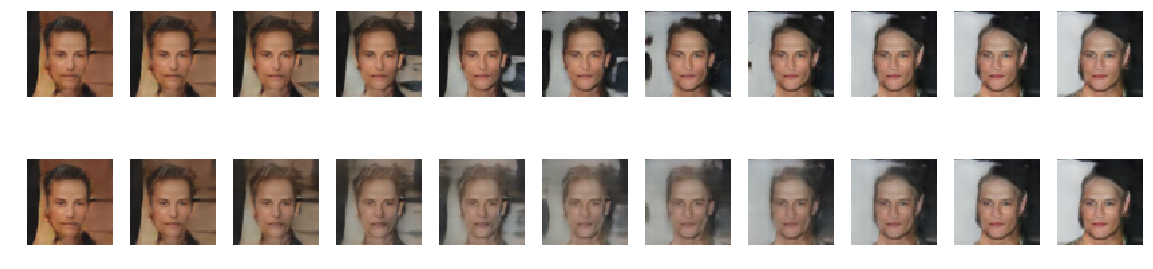

In [27]:
list_t = np.linspace(0.1, 0.9, 9)

interpolation_sequence_generation(list_t)

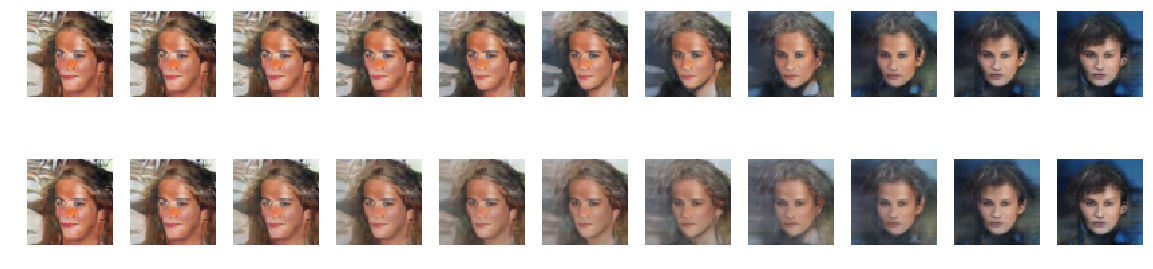

In [39]:
interpolation_sequence_generation(list_t)

### 4 point interpolation

In [43]:
def n_point_interpolation(tensors, coef_tensor, do_scale=False):
    assert coef_tensor.sum(0) == 1
    scaling_factor = (coef_tensor**2).sum(0)**0.5
#     print(coef_tensor.size())
#     print(tensors.size())
    resulting_tensor = (coef_tensor.unsqueeze(1) * tensors).sum(0).view(1, 100, 1, 1)
#     print(resulting_tensor.size())
    if do_scale:
        return resulting_tensor / scaling_factor
    else:
        return resulting_tensor

In [44]:
from IPython.core.debugger import set_trace

In [45]:
coefficients = [[[1,0,0,0],[3/4,0,0,1/4],[1/2,0,0,1/2],[1/4,0,0,3/4],[0,0,0,1]],
               [[3/4,1/4,0,0],[1/2,1/4,0,1/4],[1/4,1/4,0,1/2],[0,1/4,0,3/4],[0,0,1/4,3/4]],
               [[1/2,1/2,0,0],[1/4,1/2,0,1/4],[1/4,1/4,1/4,1/4],[1/4,0,1/4,1/2],[0,0,1/2,1/2]],
               [[1/4,3/4,0,0],[1/4,1/2,0,1/4],[1/4,1/2,0,1/4],[0,1/4,1/2,1/4],[0,0,3/4,1/4]],
               [[0,1,0,0],[0,3/4,1/4,0],[0,1/2,1/2,0],[0,1/4,3/4,0],[0,0,1,0]]]
coefficients = torch.tensor(coefficients)

In [46]:
def interpolation_4_generation():
    rand1 = torch.randn(100, device='cpu')
    rand2 = torch.randn(100, device='cpu')
    rand3 = torch.randn(100, device='cpu')
    rand4 = torch.randn(100, device='cpu')
    R = torch.stack([rand1, rand2, rand3, rand4])
    fig, axs = plt.subplots(nrows=5, ncols=10, sharex=True,figsize = (50,25))
    for i in range(5):
        for j in range(5):
            plot_torch_picture(netG.main(
                n_point_interpolation(R, coefficients[i,j], do_scale=True)), ax = axs[i,j]) 
            plot_torch_picture(netG.main(
                n_point_interpolation(R, coefficients[i,j], do_scale=False)), ax = axs[i,j+5]) 
            #set_trace()
    pass

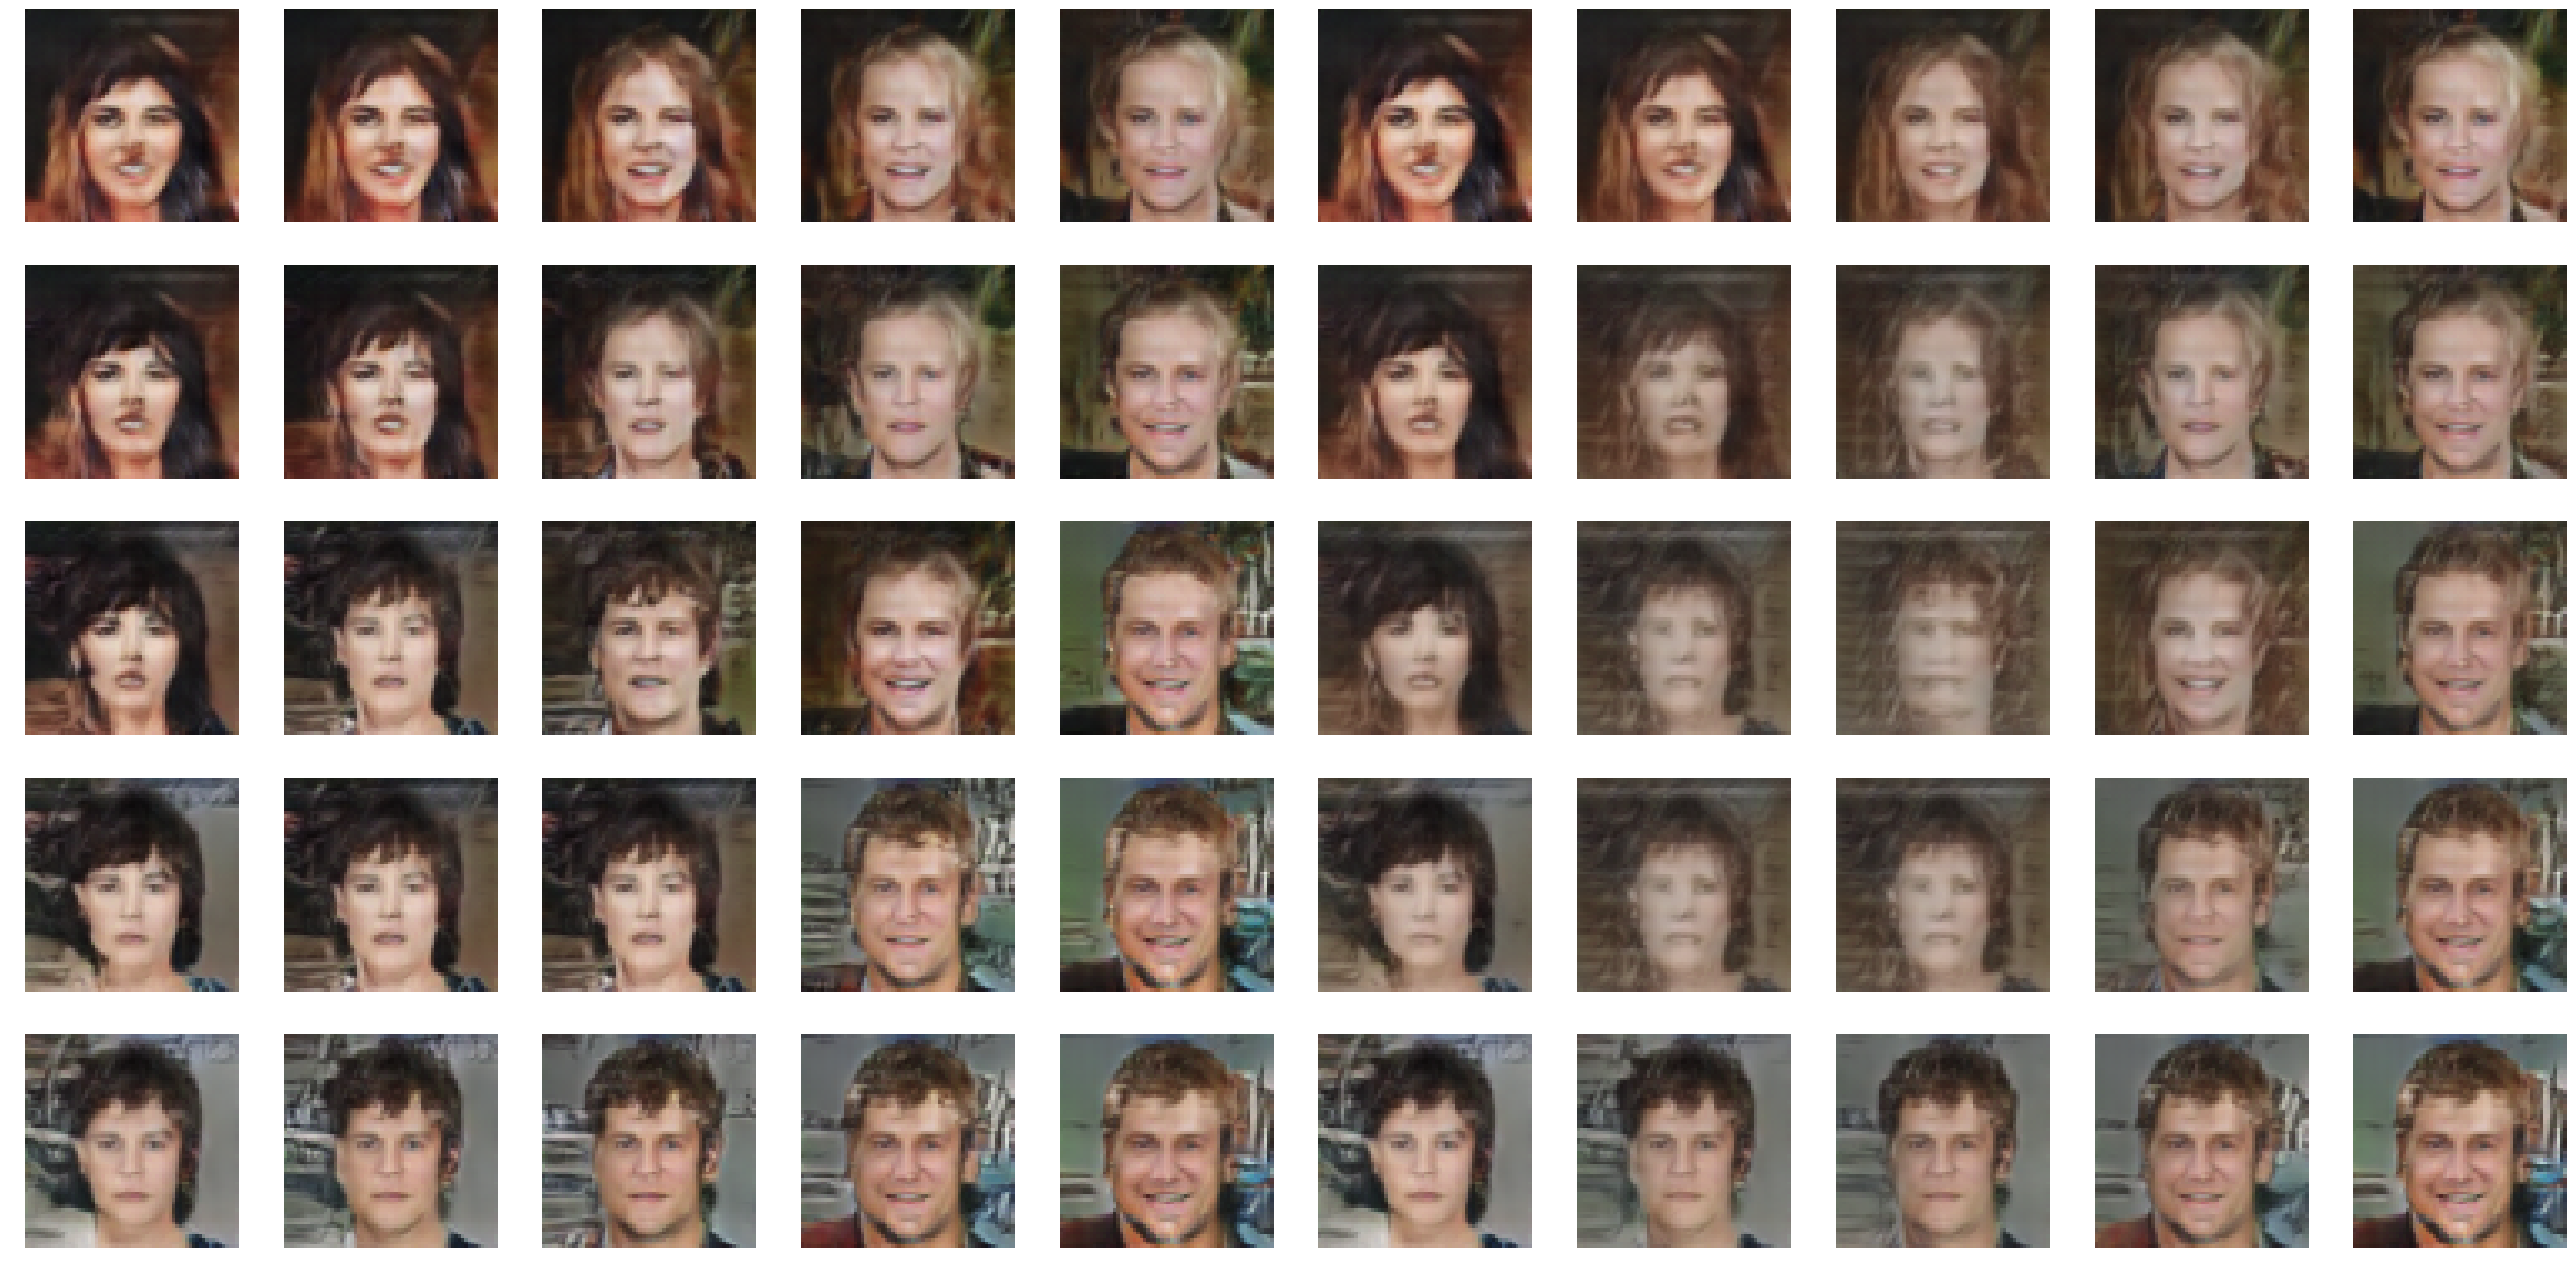

In [51]:
interpolation_4_generation()

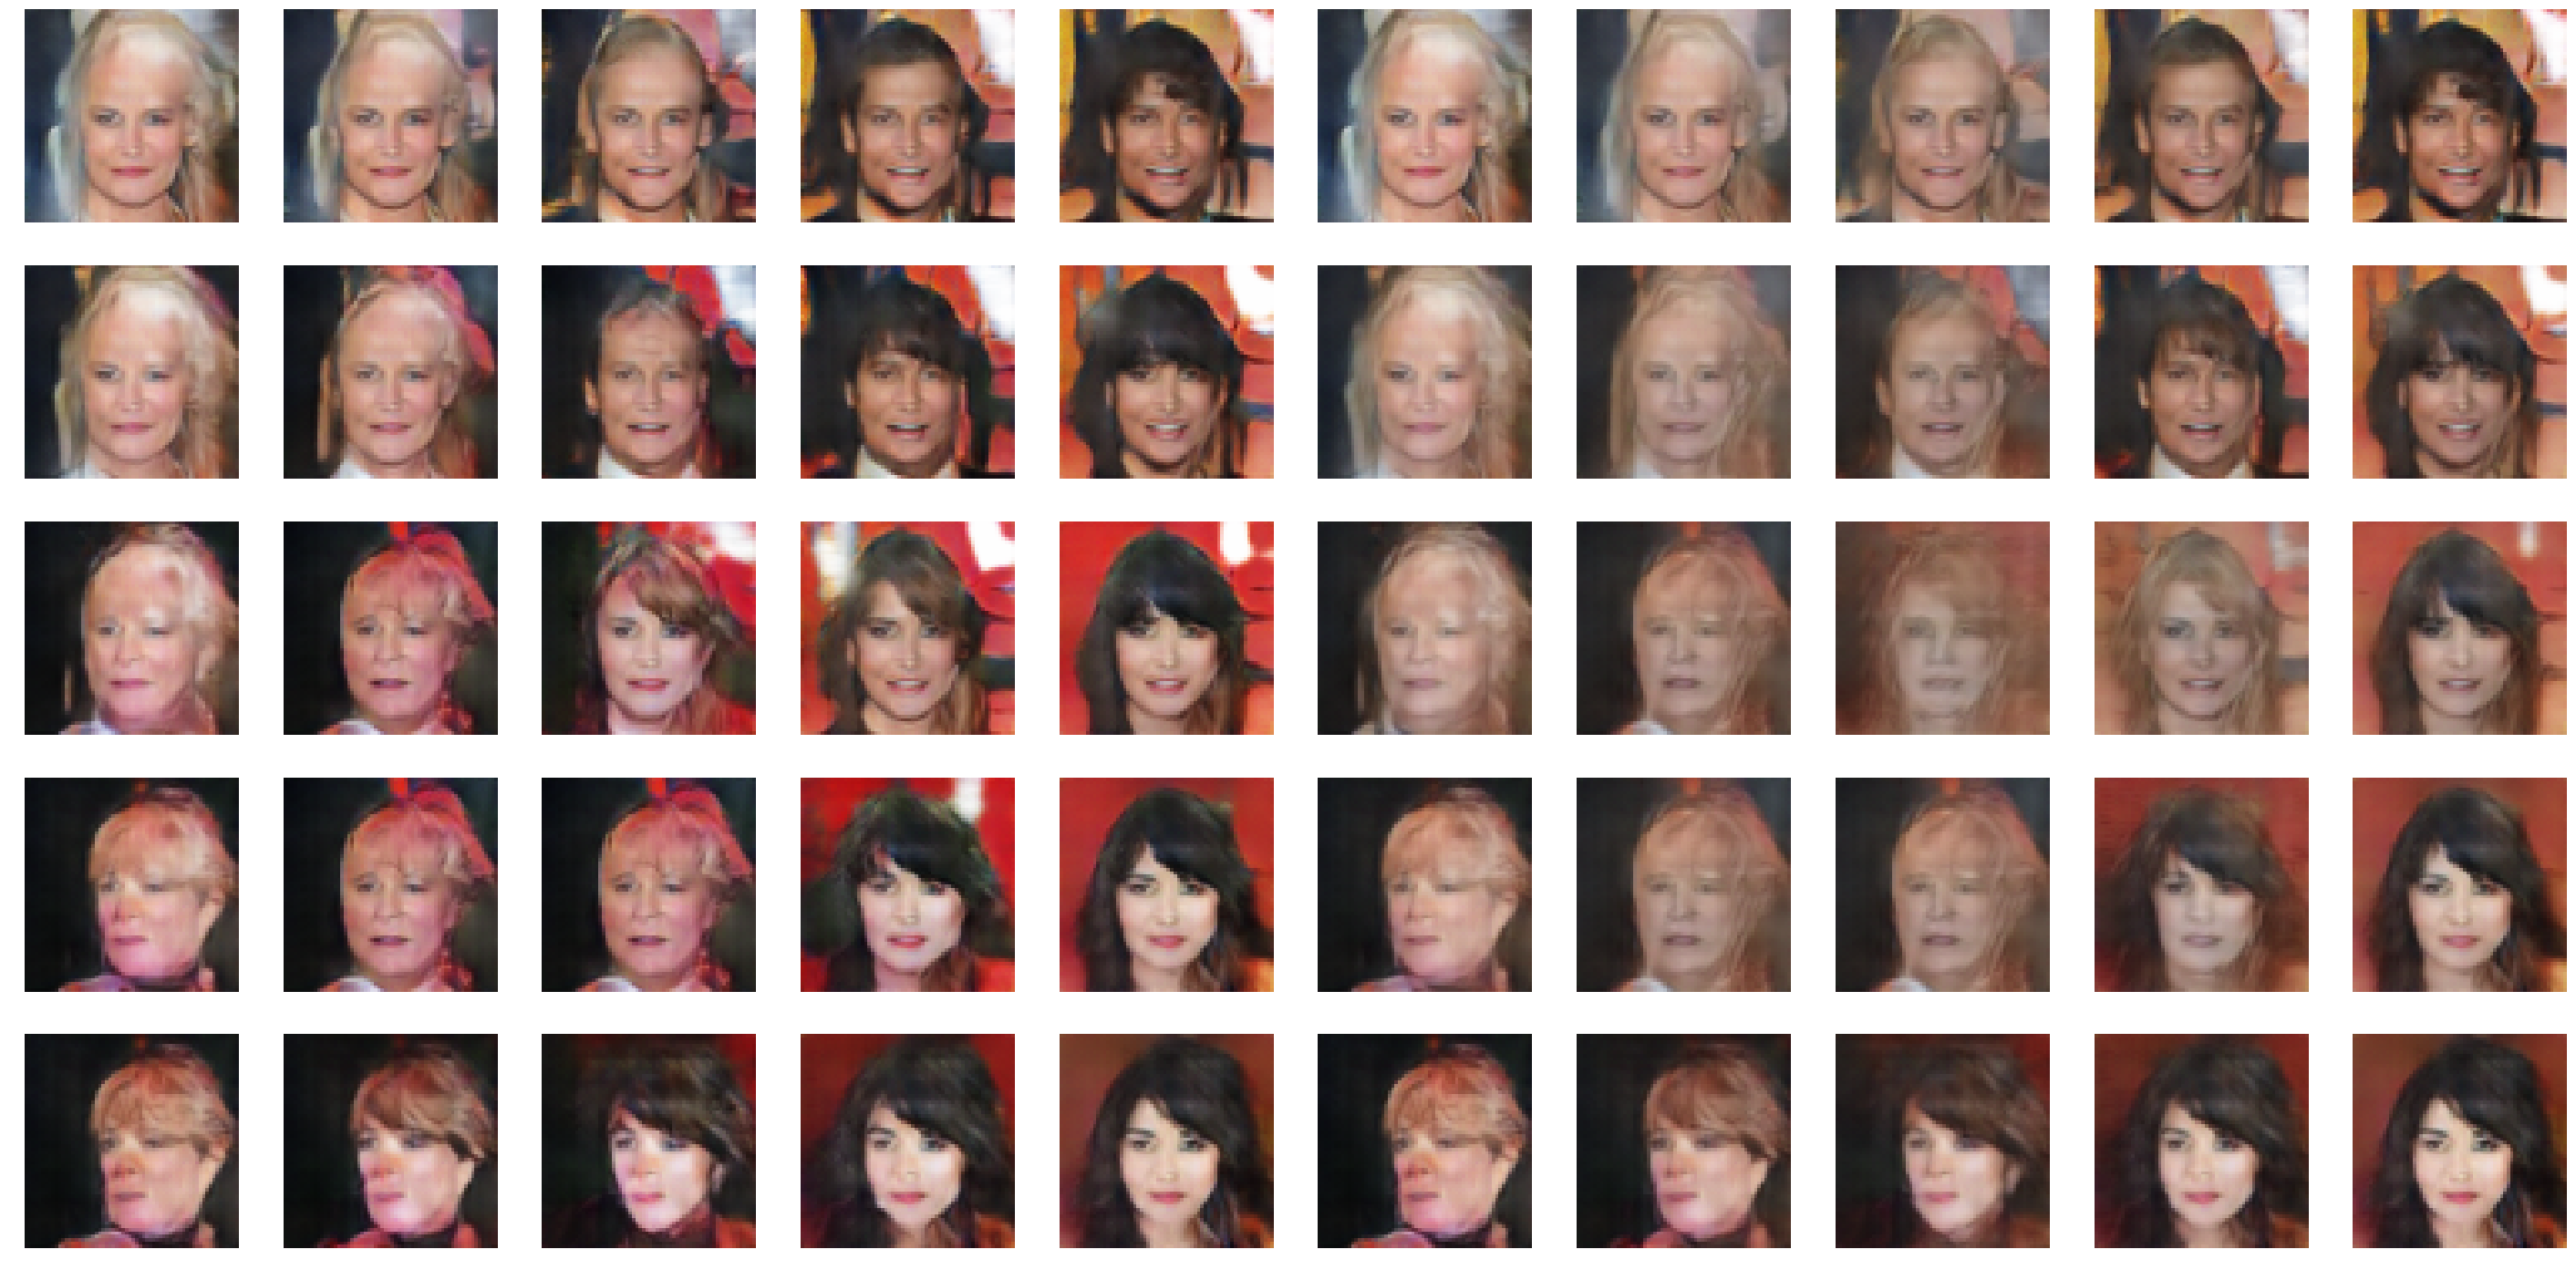

In [48]:
interpolation_4_generation()

### Random_walk

In [53]:
def rw_sample_sequence(n = 10, eps = 0.5):
    rand_shifted_no_scale = vicinity_sampling(rand, torch.zeros_like(rand), eps=eps, do_scale=False)
    rand_shifted = vicinity_sampling(rand, torch.zeros_like(rand), eps=eps)

    fig, ax = plt.subplots(nrows=2, ncols=n, figsize=(25,5))
    for i in range(10):
        shift = torch.randn_like(rand_shifted)
        rand_shifted_no_scale = vicinity_sampling(rand_shifted_no_scale, shift, eps=eps, do_scale=False)
        rand_shifted = vicinity_sampling(rand_shifted, shift, eps=eps)
        plot_torch_picture(netG.main(rand_shifted), ax=ax[0,i])
        plot_torch_picture(netG.main(rand_shifted_no_scale), ax=ax[1,i])
        
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    pass

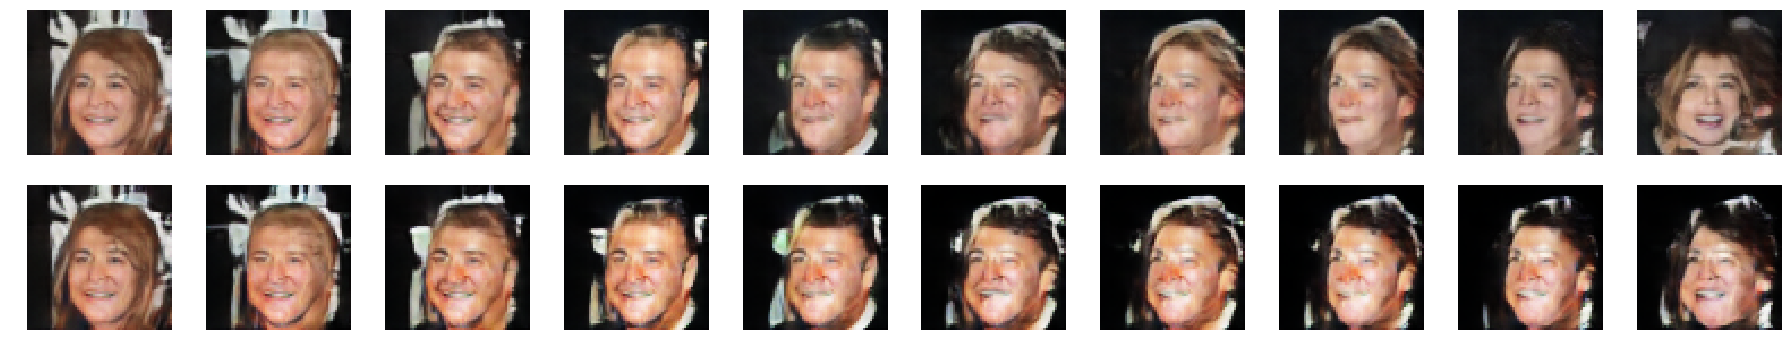

In [54]:
rw_sample_sequence()

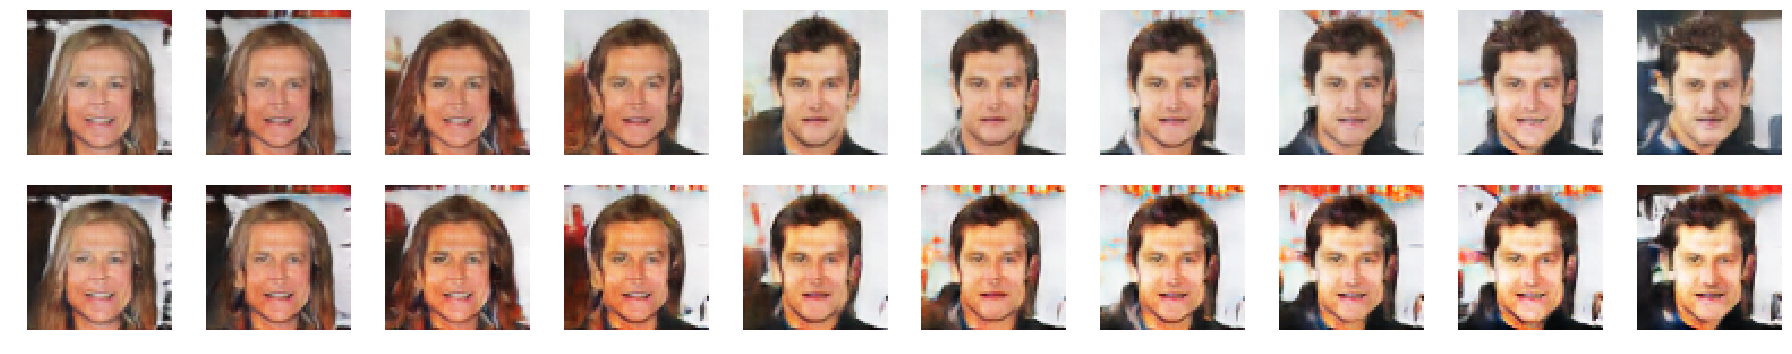

In [60]:
rw_sample_sequence()

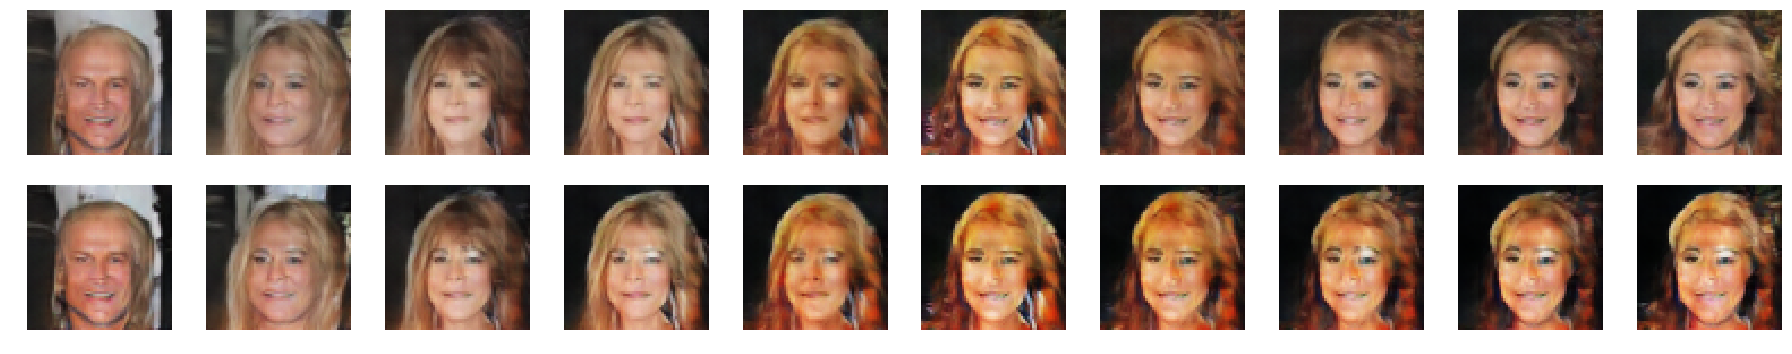

In [64]:
rw_sample_sequence()

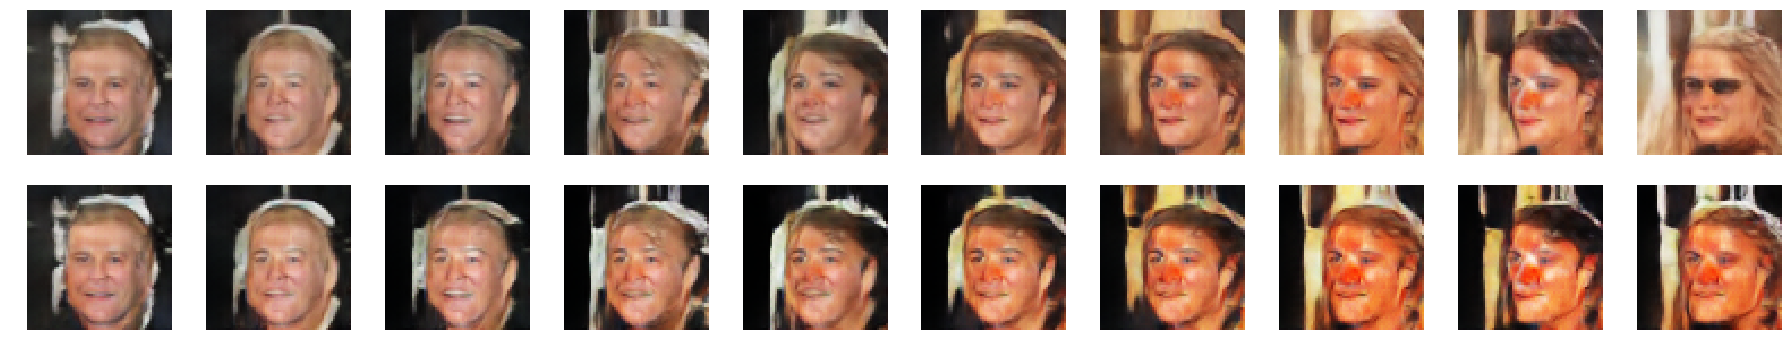

In [66]:
rw_sample_sequence()

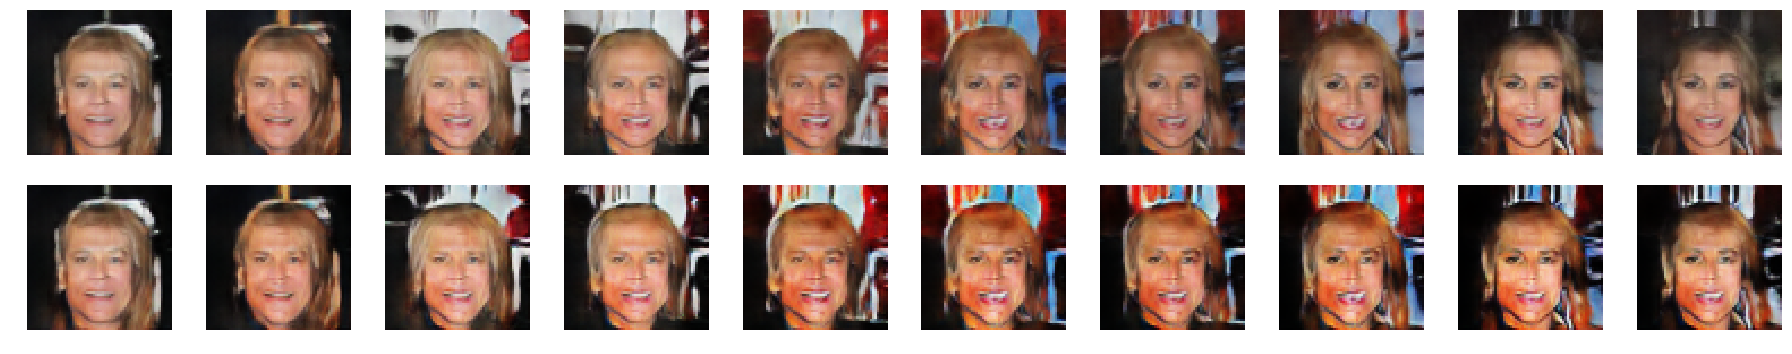

In [70]:
rw_sample_sequence()